In [39]:
stt_pecha_tools = "01_stt_pecha_tools.tsv"
prodigy = "02_prodigy.tsv"
mv = "03_mv_saymore.tsv"

In [40]:
import pandas as pd
pecha_tools_df = pd.read_csv(stt_pecha_tools, sep='\t')
prodigy_df = pd.read_csv(prodigy, sep='\t')
mv_df = pd.read_csv(mv, sep='\t')

In [41]:
df = pd.concat([pecha_tools_df, prodigy_df, mv_df], ignore_index=True)

In [42]:
bad_apples = pd.read_csv('04_bad_apples.csv')

In [43]:
df = df[~df['file_name'].isin(bad_apples['file_name'])]

In [44]:
df.drop_duplicates(subset='file_name', keep="first", inplace=True)

# clean the combined tsv

In [45]:
import re
def clean_transcription(text):
    text = text.replace('\n', ' ')
    text = text.replace('\t', ' ')
    text = text.strip()

    text = re.sub(r"་+", "་", text)
    text = re.sub(r"།+", "།", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\s+།", "།", text)

    text = re.sub(r"ཧཧཧ+", "ཧཧཧ", text)
    text = re.sub(r'འེ་འེ་(འེ་)+', r'འེ་འེ་འེ་', text)
    text = re.sub(r'ཧ་ཧ་(ཧ་)+', r'ཧ་ཧ་ཧ་', text)

    chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\/\{\}\(\)\༽\》\༼\《\༅\༄\༈\༑\༠]'
    
    text = re.sub(chars_to_ignore_regex, '', text)+" "
    return text

def check_if_regex(text):
    text = str(text)
    regex = re.compile(r'[a-zA-Z]+')
    match = re.search(regex, text)
    
    return bool(match)
    
print(check_if_regex('ཧཧ'))
print(check_if_regex('some text'))

False
True


In [46]:
df = df[df['uni'].str.len() > 0]

In [47]:
df = df[~df['uni'].apply(check_if_regex)]

In [48]:
df['uni'] = df['uni'].map(clean_transcription)

In [49]:
! pip install pyewts

In [50]:
import pyewts

converter = pyewts.pyewts()

df['wylie'] = df['uni'].apply(converter.toWylie)

In [51]:
df['char_len'] = df['uni'].str.len()

In [52]:
! pip install matplotlib

<Axes: >

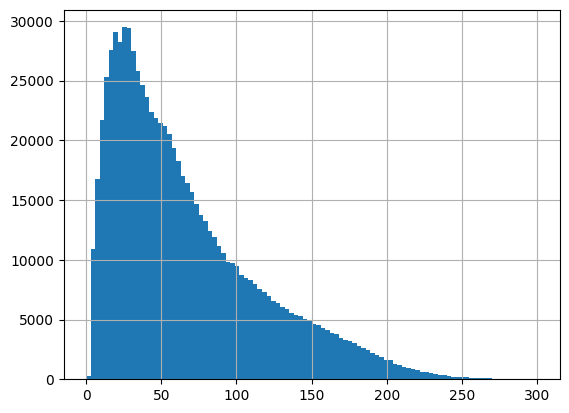

In [53]:
df['char_len'].hist(bins=100, range=(0, 300))

In [54]:
df['char_len'].describe()

count    804124.000000
mean         66.229727
std          60.770189
min           1.000000
25%          28.000000
50%          53.000000
75%          93.000000
max       23249.000000
Name: char_len, dtype: float64

In [55]:
df.shape[0]

804124

In [56]:
upper_cutoff = 400
lower_cutoff = 5

In [57]:
df[df['char_len'] > upper_cutoff].shape[0], df[df['char_len'] < lower_cutoff].shape[0]

(3, 7769)

In [58]:
df[df['char_len'] > upper_cutoff][['uni', 'url', 'char_len']].sort_values(by='char_len').to_csv('04_longer_than_upper_cutoff.tsv', sep='\t', index=False)

In [59]:
df[df['char_len'] < lower_cutoff][['uni', 'url', 'char_len']].sort_values(by='char_len').to_csv('04_shorter_than_lower_cutoff.tsv', sep='\t', index=False)

In [60]:
df = df[(df['char_len'] < upper_cutoff) & (df['char_len'] > lower_cutoff)]

In [61]:
df.shape[0]

792935

In [62]:
def getTimeSpan(filename):

    filename = filename.replace(".wav", "")
    filename = filename.replace(".WAV", "")
    filename = filename.replace(".mp3", "")
    filename = filename.replace(".MP3", "")
    try:
        if "_to_" in filename:
            start, end = filename.split("_to_")
            start = start.split("_")[-1]
            end = end.split("_")[0]
            end = float(end)
            start = float(start)
            return abs(end - start)/1000
        else:
            start, end = filename.split("-")
            start = start.split("_")[-1]
            end = end.split("_")[0]
            end =   float(end)
            start = float(start)
            return abs(end - start)
    except Exception as err:
        print(f"filename is:'{filename}'. Could not parse to get time span.")
        return 0
    

getTimeSpan("STT_TT00031_03471.850-03477.44")

5.5900000000001455

In [63]:
df['audio_len'] = df['file_name'].apply(getTimeSpan)

In [64]:
df['audio_len'].describe()

count    792935.000000
mean          4.236541
std           3.018290
min           0.400000
25%           1.650000
50%           3.232000
75%           6.734500
max          14.050000
Name: audio_len, dtype: float64

<Axes: >

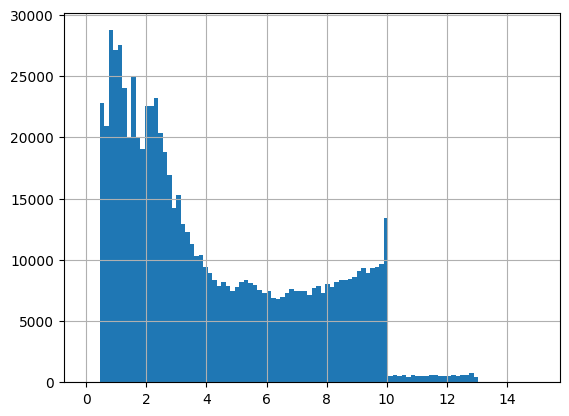

In [65]:
df['audio_len'].hist(bins=100, range=(0, 15))

In [66]:
df['url'] = df['url'].map(lambda x : x.replace('#','%23'))

In [67]:
df.to_csv('04_combine_all.tsv', sep='\t', index=False)

In [68]:
df.head()

,file_name,uni,url,dept,grade,wylie,char_len,audio_len
0,STT_NS0085_0150_1184970_to_1192294.mp3,རྒྱ་གར་ལུང་པར་དང་ཤོས་སླེབས་དུས་སྐབས་སུ་དངོས་གན...,https://d38pmlk0v88drf.cloudfront.net/stt_pech...,STT_NS,2,rgya gar lung par dang shos slebs dus skabs su...,165,7.324
1,STT_CS-L-2018_2018-M_M-D_D-B04_B04-1_1-R_R-02_...,རྒན་ལགས་ལབ་ཡི་ཡིན་ད་ང་། འདི་ལ་རྨ་བཟོས་ཡོད་ད། ཚ...,https://d38pmlk0v88drf.cloudfront.net/stt_pech...,STT_CS,2,rgan lags lab yi yin da nga /_'di la rma bzos ...,80,5.554
2,STT_AB00156_0296_1211329_to_1212494,བོད་གཞུང་བཀའ་ཤག་དང༌,https://huggingface.co/datasets/openpecha/STT_...,STT_AB,2,bod gzhung bka' shag dang*_,20,1.165
3,STT_NS_M0049_0127_838881_to_840990.mp3,ད་དེང་སང་མི་འདུག་མངར་མོ་འདྲ་བོ་ཚོར་གི་འདུག ང་འ...,https://d38pmlk0v88drf.cloudfront.net/stt_pech...,STT_NS,2,da deng sang mi 'dug mngar mo 'dra bo tshor gi...,53,2.109
4,STT_NS_M0035_0143_1065338_to_1073027.mp3,འདི་སློབ་སྦྱོང་ཡོད་མྱི་བུ་གུ་གཅིག་ཡིན་ན། འདི་འ...,https://d38pmlk0v88drf.cloudfront.net/stt_pech...,STT_NS,2,'di slob sbyong yod myi bu gu gcig yin na/_'di...,143,7.689


In [69]:
df.groupby('grade').size()

grade
2    441815
3    351120
dtype: int64

In [71]:
# len(train), len(val), len(test), len(train)+len(val)+len(test), len(df)

In [72]:
# train.to_csv('train.tsv', sep='\t', index=False)
# val.to_csv(  'val.tsv', sep='\t', index=False)
# test.to_csv( 'test.tsv', sep='\t', index=False)

In [73]:
df['uni'].str.contains('ཧཧཧ').value_counts()

uni
False    792424
True        511
Name: count, dtype: int64

In [91]:
import pandas as pd

df = pd.read_csv('04_combine_all.tsv', sep='\t')

In [75]:
df.head()

,file_name,uni,url,dept,grade,wylie,char_len,audio_len
0,STT_NS0085_0150_1184970_to_1192294.mp3,རྒྱ་གར་ལུང་པར་དང་ཤོས་སླེབས་དུས་སྐབས་སུ་དངོས་གན...,https://d38pmlk0v88drf.cloudfront.net/stt_pech...,STT_NS,2,rgya gar lung par dang shos slebs dus skabs su...,165,7.324
1,STT_CS-L-2018_2018-M_M-D_D-B04_B04-1_1-R_R-02_...,རྒན་ལགས་ལབ་ཡི་ཡིན་ད་ང་། འདི་ལ་རྨ་བཟོས་ཡོད་ད། ཚ...,https://d38pmlk0v88drf.cloudfront.net/stt_pech...,STT_CS,2,rgan lags lab yi yin da nga /_'di la rma bzos ...,80,5.554
2,STT_AB00156_0296_1211329_to_1212494,བོད་གཞུང་བཀའ་ཤག་དང༌,https://huggingface.co/datasets/openpecha/STT_...,STT_AB,2,bod gzhung bka' shag dang*_,20,1.165
3,STT_NS_M0049_0127_838881_to_840990.mp3,ད་དེང་སང་མི་འདུག་མངར་མོ་འདྲ་བོ་ཚོར་གི་འདུག ང་འ...,https://d38pmlk0v88drf.cloudfront.net/stt_pech...,STT_NS,2,da deng sang mi 'dug mngar mo 'dra bo tshor gi...,53,2.109
4,STT_NS_M0035_0143_1065338_to_1073027.mp3,འདི་སློབ་སྦྱོང་ཡོད་མྱི་བུ་གུ་གཅིག་ཡིན་ན། འདི་འ...,https://d38pmlk0v88drf.cloudfront.net/stt_pech...,STT_NS,2,'di slob sbyong yod myi bu gu gcig yin na/_'di...,143,7.689


In [76]:
df.groupby('dept')['audio_len'].sum()/60/60

dept
STT_AB     97.767446
STT_CS     76.414307
STT_MV    411.344231
STT_NS    127.994143
STT_TT    219.619146
Name: audio_len, dtype: float64

In [77]:
df['audio_len'].sum()/60/60

933.1392719444445

In [78]:
# df.sort_values(by='audio_len', ascending=False, inplace=True)
df = df.sample(frac = 1)

In [79]:
df.iloc[0:100,[0, 1, 3, 5]].to_csv("04_random_100.tsv", index=False, sep='\t')
df.iloc[0:100,[0, 1, 3, 5]].head()

,file_name,uni,dept,wylie
633628,STT_MV0521_0099_922987_to_929790,ཉིན་མ་གཅིག་ཞབས་སྐོར་ཐེད་མྱི་ཨ་མ་ལགས་གཅིག་གིས་བ...,STT_MV,nyin ma gcig zhabs skor thed myi a ma lags gci...
427945,STT_TT00195_00608.950-00610.650,སྣ་རལ་བསྡད་དེར་ང་ཚོའི་ཟབ་ཟབ་ཟས་ཟས་བྱེད་ཆོག,STT_TT,sna ral bsdad der nga tsho'i zab zab zas zas b...
741225,STT_MV0347_0178_1535591_to_1540422,ཨ་མ་བྱས་ཨ་མ་འདིས་བཞག་ཨ་ཅག་འདིས་བཞག,STT_MV,a ma byas a ma 'dis bzhag a cag 'dis bzhag_
632062,STT_MV0501_0213_1626114_to_1632487,ཨུ་ཨ་ཨ་ཨ་ རྒྱས་སྲས་མཆོག་ ཨུམ་ཨ་ཨུམ་ ཚུགས་ཟིན་ག...,STT_MV,u a a a _rgyas sras mchog _um a um _tshugs zin...
545295,STT_TT00033_01693.700-01698.750,རང་ཉིད་བདེ་བ་འདོད་པ་སྡུག་བསྔལ་མི་འདོད་པ་རྒྱུ་མ...,STT_TT,rang nyid bde ba 'dod pa sdug bsngal mi 'dod p...


In [80]:
df[df['grade'] == 3].groupby('dept').size()

dept
STT_AB       147
STT_CS     37314
STT_NS     42587
STT_TT    271072
dtype: int64